## Changes from default:

## Effect of changes:
N/A

## 0. Overview

"Quantifying unstructured and noisy textual content is complex and involves numerous methodological issues related to the preprocessing of the data and the optimization of the algorithm used to quantify textual content. The number of **text preprocessing** that can be implemented is numerous (**lowercase**, **stemming**, **lemma-tization**, part-of-speech tagging, **stopwords removal**, **punctuation removal**, etc.) and it is not easy to identify which transformation increases (decreases) the accuracy of the classiﬁcation. The same is true for the choice of the algorithm: the large number of algorithms (Naive Bayes, SVM, logistic regression, random forest, multilayer perceptron, etc.) and the even greater number of hyperparameters for each algorithm lead to an immense number of combinations.Furthermore, the answers relative to those methodological issues strongly depend on the type of data used (informal or formal content, short or long text), on the size of the dataset (few hundreds or mil-lions of documents), on the availability of pre-classiﬁed messages (supervised or unsupervised learning), and on the type of documents (domain-speciﬁc or generic documents). While there is no one-ﬁts-all solution, we nonetheless believe that some guidance and tips can help researchers to avoid common mistakes."

Renault, Thomas. (2020). Sentiment analysis and machine learning in finance: a comparison of methods and models on one million messages. Digital Finance. 2. 10.1007/s42521-019-00014-x. pp. 2

## 1. Import

In [1]:
#import nltk
#nltk.download('all-corpora')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words_set = set(stopwords.words('english'))

## 2. Load data
Current status: Default (~5000 tweets)

In [2]:
# Change this in testing.
data = pd.read_csv('stock_data.csv')


## 3. Define Clean and Lower

In [3]:
def clean_and_lower(text):
    '''
    Input:
        A string of messy data
    Output:
        A string of clean lowercase data
    
    1) Replacing everything that isn't a letter with a space (special characters, numbers)
    2) Sending all text to lowercase
    '''
    clean_text = re.sub('[^a-zA-Z]'," ", text)
    clean_text = clean_text.lower()
    return clean_text



## 4. Define Tokenize
Current status: Default

In [4]:
def tokenize_data(text):
    '''
    Input:
        A string of cleaned data
    Output:
        A list of the words in the string
        
    Will split the string into tokens based on what nltk package thinks is best.
    Not sure how different it is compared to string.split(' ')
    
    There is also a TwitterTokenizer, maybe something to look into if we want to deal with 
        emojiis instead of replacing them with spaces.
    '''
    return word_tokenize(text, language='english')

## 5. Define Lemmatize and Stopword removal
Current status: Lemmatization on

Stopword removal on

In [5]:
def lemma_and_stopwords(text, remove_stop_words=False):
    '''
    Input:
        List of words that have been cleaned and tokenized
    Output:
        A string that is supposed to represent the meaning of the original sentence, as reduced as possible
        
        
    From from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    "
        Lemmatization is the process of converting a word to its base form. The difference 
            between stemming and lemmatization is, lemmatization considers the context and 
            converts the word to its meaningful base form, whereas stemming just removes the 
            last few characters, often leading to incorrect meanings and spelling errors.

        For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care’, 
            whereas, stemming would cutoff the ‘ing’ part and convert it to car.

        ‘Caring’ -> Lemmatization -> ‘Care’
        ‘Caring’ -> Stemming -> ‘Car’
    "
    
    
    Since the original paper also mentioned stop words, I made sure the word is not a stop word
    before trying to convert it. I ran it with and without the stop word and I didn't notice much difference
    but maybe it's something to fiddle with later.
    
    
    EDIT 1: The paper also mentioned 'part-of-speech' tagging, which seems to attach context to each word to help
    convert its meaning properly. Since this seemed more complicated, and this isn't a text processing project,
    I didn't do it. 
    However there is an entire coded example (example 3) here: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    so it might be quick to implement and see if it improves our classification scores after
    
    EDIT 2:
    About stop words, from the paper: 
        We also ﬁnd that removing stopwords using the NLTK stopwords corpus signiﬁcantly decreases the accuracy 
        of the classiﬁcation. We believe that this result is due to the fact that the stopwords corpus from NLTK includes 
        words that could be very useful for sentiment analysis in ﬁnance such as “up”, “down”, “below” or “above”. Thus, 
        researchers should not use the standard NLTK list and should consider a more restrictive list of stopwords for 
        sentiment analysis (“a”, “an”, “the”...). This result is consistent with Saif et al (2014) who show that Naive 
        Bayes classiﬁers are more sensitive to stopword removal and that using pre-existing lists of stopwords negatively 
        impacts the performance of sentiment classiﬁcation for short-messages posted on social media.
    '''
    if remove_stop_words:
        list_of_words = [lemmatizer.lemmatize(word) for word in text if(word) not in stop_words_set]
    else:
        list_of_words = [lemmatizer.lemmatize(word) for word in text]
        
    string_of_words = " ".join(list_of_words)
    return string_of_words

## 6. Final preprocessing

In [6]:
def prep_all_data(data, remove_stop_words=False):
    '''
    Input:
        The column of the dataframe that contains text
    Output:
        A list of strings that has been through:
            clean_data = clean_and_lower(data)
            token_data = tokenize_data(clean_data)
            lemma_data = lemma_and_stopwords(token_data)
    '''
    list_of_nice_strings = []
    for i in data:
        clean_string = clean_and_lower(i)
        token_list = tokenize_data(clean_string)
        lemma_string = lemma_and_stopwords(token_list, remove_stop_words=remove_stop_words)
        list_of_nice_strings.append(lemma_string)
        
    return list_of_nice_strings

# Note: Just eyeballing it, it looks like some words that are useful are being thrown out
# I.e in fourth row (index 3) it goes from "MNTA Over 12" --> "mnta". It seems like that is a bullish tweet, but something
# is throwing away the "over".
# EDIT: I just tried without "stop words" and it recovered the "Over"... Best to try both

clean_data = prep_all_data(data['Text'])


## 7. Vectorization
Current status:

Vectorization: CountVectorizer

n-grams: 1 and 2

In [7]:
def text_to_num(clean_data):
    '''
    Input: 
        cleaned list of strings
    Output:
        Numerical vector representation [0's and 1's]
    
    From: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
    More info: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    
    Text Analysis is a major application field for machine learning algorithms. However,
        the raw data, a sequence of symbols cannot be fed directly to the algorithms 
        themselves as most of them expect numerical feature vectors with a fixed size 
        rather than the raw text documents with variable length.
    ...       
    We call vectorization the general process of turning a collection of text documents into numerical 
        feature vectors. This specific strategy (tokenization, counting and normalization) is called 
        the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences 
        while completely ignoring the relative position information of the words in the document.
    '''
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Like usual we may need to cross validate this to determine the optimal represenation
    # Cross validation link: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py
    # max_features = ?
    # ngram_range = ?
    # fit_transform: Learn the vocabulary dictionary and return document-term matrix.
    # EDIT: He has results in his paper about choosing good parameters for ngrams

    vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3)
    document_term_matrix = vectorizer.fit_transform(clean_data).toarray()
    return document_term_matrix
    

## 8. Dimension reduction
Current status:

No dimension reduction.

<AxesSubplot:>

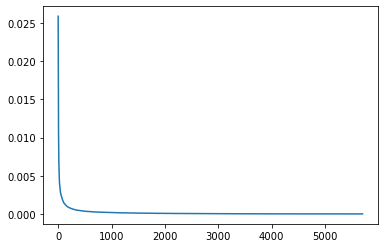

In [8]:
# None by default.
# When we add this, we'll do it off the X matrix here.

X = text_to_num(clean_data)
y = data["Sentiment"]
y = y.replace(-1, 0)

# Let's try SVD
from sklearn.decomposition import TruncatedSVD
n_components = 5700
SVD = TruncatedSVD(n_components=n_components)
SVD.fit(X)
plot_x = np.arange(5700)
plot_y = SVD.explained_variance_ratio_
sns.lineplot(x=plot_x, y=plot_y)

Past ~100, we can see that the marginal increase from any given additional component is quite small.

Conversely, at 1000, we have only explained about 80% of variance; there are a lot of components required to explain the last few percentage points of variance.

I will try a few values of decomposition.

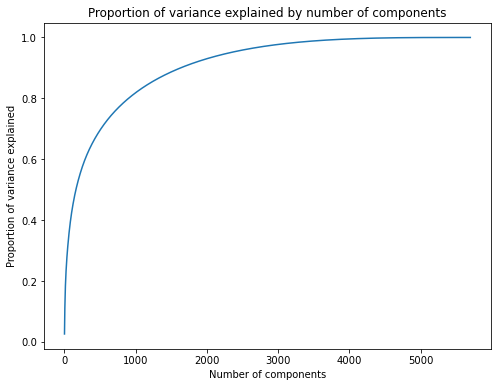

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(x=plot_x, y=plot_y, ax=axs)
axs.set(title='Proportion of variance explained by number of components',
       xlabel='Number of components',
       ylabel='Proportion of variance explained')
None

In [ ]:
plot_x = np.arange(5700)
plot_y = SVD.explained_variance_ratio_
sns.lineplot(x=plot_x, y=plot_y)
None

In [ ]:
help(SVD)

## 9. Training/Testing split

In [ ]:
from sklearn.model_selection import train_test_split


print("X Shape: {}".format(X.shape))
# Should we do PCA on this? X is (5791, 8330)....
# from sklearn.decomposition import PCA
# n_components=250
# pca = PCA(n_components=n_components) 
# X_reduced = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)


## 10. Model list definition:
Current status: Multinomial NB, Logistic Regression, SVM, Random Forest

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models_to_try = []

# Multinomial Naive Bayes
models_to_try.append(("MultinomialNB",MultinomialNB()))

# Gaussian Naive Bayes
# Fitting gaussing naive bayes (like in class) instead
# models_to_try.append(("GaussianNB", GaussianNB()))

# Logistic Regression
models_to_try.append(("LogisticReg", LogisticRegression()))

# Support Vector Machine
models_to_try.append(("SVC", SVC()))
# models_to_try.append(("SVC", SVC(probability=True))) # Need this to use .predict_proba()

# Random Forest
models_to_try.append(("RandomForest", RandomForestClassifier()))

# Multilayer Perceptron 
# Not going to fit a multilayer perceptron, here's XGB instead
#models_to_try.append(("XGB", XGBClassifier()))

## 11. Results

In [17]:
from sklearn.metrics import  roc_auc_score
def prediction_results(models_to_try, X_train, X_test, y_train, y_test):
    '''
    Input:
        models_to_try: a list of tuples ("Name as a string", object)
        Data as usual
    Ouput:
        Prints the accuracy and returns a dictionary to create a confusion matrix
    
    '''
    confused_dict=dict()
    for name, classifier in models_to_try:

        classifier.fit(X_train, y_train)
            
        preds = classifier.predict(X_test)
        print("{} Accuracy: {}".format(name, accuracy_score(y_test, preds)))
        
        if name != "SVC":
            probs = classifier.predict_proba(X_test)[:, 1]
            print("{} AUC: {}".format(name, roc_auc_score(y_test, probs)))
            
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        
        MCC = (tp*tn - fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print("{} MCC: {}".format(name, MCC))
        confused_dict[name] = [tn, fp, fn, tp]
        
        
    return confused_dict

from sklearn.metrics import confusion_matrix, accuracy_score
confused_dict = prediction_results(models_to_try, X_train, X_test, y_train, y_test)

def dict_to_output(confused_dict):
    for key, value in confused_dict.items():
        print("{} Confusion Matrix".format(key))
        print(pd.DataFrame({"True Y=1":[value[3],value[2]],"True Y=0":[value[1],value[0]]},index=["Guess Y=1","Guess Y=0"]))
        print("\n")
        
dict_to_output(confused_dict)

NameError: name 'models_to_try' is not defined